In [425]:
from bs4 import BeautifulSoup
from tqdm import tqdm
import requests
import csv
import re

def getAndParseURL(url):
    result = requests.get(url)
    soup = BeautifulSoup(result.text, 'html.parser')
    return(soup)

def get_appearances(pokemon_soup):
    names = [table_name.get('href')[1:] for table_name in pokemon_soup.find('p').findAll('a')]
    regex = re.compile('key.*')
    appearances,i = {},0
    for table in pokemon_soup.findAll("table"):
        lines = table.findAll("td",{"class":regex})
        if len(lines) > 0:
            appearances[names[i]] = [line.text for line in lines]        
            i += 1
    return appearances

def dexnum(base_url):
    bulbasoup = getAndParseURL(base_url+'001.shtml')
    tuples=re.findall(r'\n([0-9]{3})\ +(\w+.*\w+)',bulbasoup.text)
    return {int(num_str):name for num_str,name in tuples}
        

In [426]:
base = 'https://www.serebii.net/anime/dex/'
dex = dexnum(base)
AppDict = {poke:get_appearances(getAndParseURL(f'{base}{num:03}.shtml')) for num,poke in tqdm(dex.items())}


100%|████████████████████████████████████████████| 898/898 [05:25<00:00,  2.76it/s]


In [436]:
import pandas as pd
poke = pd.DataFrame(AppDict)
poke.to_csv('temp')
poke = pd.read_csv('temp',index_col=0)

In [471]:
from collections import defaultdict
d = defaultdict(list)

for poke,group in tqdm(AppDict.items()):
    for title,eps in group.items():
        for ep in eps:
            d[ep].append((poke,title))

100%|█████████████████████████████████████████| 898/898 [00:00<00:00, 75532.13it/s]


In [476]:
eps = pd.Series(d)
exploded = eps.to_frame().explode(0)
episodes = pd.DataFrame(data=exploded[0].to_list(),index=exploded.index,columns=['Pokemon','sub'])
episodes.to_csv('epslist')

In [504]:
episodes = pd.read_csv('epslist',index_col=0)

<AxesSubplot:ylabel='Count'>

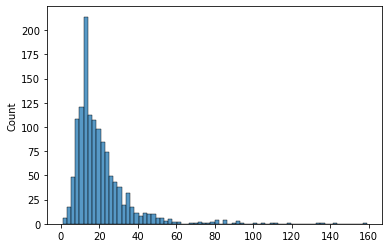

In [511]:
import seaborn as sns
sns.histplot(episodes.index.value_counts())

In [531]:
episodes.index.unique().sort_values()[:40]

Index(['1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005',
       '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013',
       '1014', '1015', '1016', '1017', '1018', '1019', '102', '1020', '1021',
       '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '103',
       '1030', '1031', '1032', '1033'],
      dtype='object')

In [541]:
episodes['sub'].value_counts()[:60]

wild                     6213
special/othertrainers    4434
ash                      4062
jessie                   1261
rocket                   1128
goh                       782
james                     674
brock                     599
misty                     554
dawn                      518
clemont                   350
may                       329
iris                      260
kiawe                     222
sophocles                 203
nursejoy                  187
lana                      171
serena                    169
mallow                    134
lillie                    129
cilan                     124
paul                      116
pokeride                  110
gladion                   102
mewtwo                     75
samsonoak                  60
chloe                      58
officerjenny               52
lusamine                   50
giovanni                   46
zoey                       42
gary                       41
professorkukui             41
sawyer    

In [546]:
episodes.index.unique()

Index(['10', '12', '13', '15', '16', '17', '18', '19', '20', '22',
       ...
       'S26', 'S36', 'G9', 'G12', 'G11', 'G14', 'G13', 'G15', 'G16', 'G17'],
      dtype='object', length=1292)